# Handcrafted Features (Supervised Learning)

This notebook demonstrates the process of detecting OOD images by using handcrafted features such as RGB, HSL, entropy, and contrast to feed into a supervised learning model. This notebook contains code for training on `bollworms-clean-train` and testing on `bollworms-clean-test`.

# Imports

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K

# Navigate to to `OOD directory`

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Replace [OOD_DETECTION_REPOSITORY] with the correct location
os.chdir('/content/drive/[OOD_DETECTION_REPOSITORY]')
!git pull

### Build Training Dataset

In [3]:
from data_utils.datasets import find_image_files, build_dataset

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

# Build training sets of ID and OOD images
train_id_df = find_image_files('data/bollworms-clean-train/ID')
train_id_ds = build_dataset(train_id_df, augment=False, shuffle=False, **ds_kwargs)
train_ood_df = find_image_files('data/bollworms-clean-train/OOD')
train_ood_ds = build_dataset(train_ood_df, augment=False, shuffle=False, **ds_kwargs)

# Build testing sets of ID and OOD images
test_id_df = find_image_files('data/bollworms-clean-test/ID')
test_id_ds = build_dataset(test_id_df, augment=False, shuffle=False, **ds_kwargs)
test_ood_df = find_image_files('data/bollworms-clean-test/OOD')
test_ood_ds = build_dataset(test_ood_df, augment=False, shuffle=False, **ds_kwargs)
     
# Build external test sets of Stanford Dogs
stanford_dogs_df = find_image_files('data/stanford_dogs/Images/*')
stanford_dogs_df = stanford_dogs_df.sample(frac=1, random_state=297) # Shuffle the data frame to get dogs of all types from top to bottom
stanford_dogs_ds = build_dataset(stanford_dogs_df.iloc[:3000,:], augment=False, shuffle=False, **ds_kwargs) # Use the first 3000 as a test

# Build external test sets of Oxford Flowers 102
flowers102_df = find_image_files('data/flowers102/*')
flowers102_df = flowers102_df.sample(frac=1, random_state=297) # Shuffle the data frame to get flowers of all types from top to bottom
flowers102_ds = build_dataset(flowers102_df.iloc[:3000,:], augment=False, shuffle=False, **ds_kwargs) # Use the first 3000 as a test

Found 5800 image files in folder "data/bollworms-clean-train/ID"
Found 2954 image files in folder "data/bollworms-clean-train/OOD"
Found 645 image files in folder "data/bollworms-clean-test/ID"
Found 328 image files in folder "data/bollworms-clean-test/OOD"
Found 20580 image files in folder "data/stanford_dogs/Images/*"
Found 1620 image files in folder "data/flowers102/*"


# Generate handcrafted features

* We generate a series of handcrafted features based on data available in `bollworms-train`. 
* Features include the mean of each RGB channel, variance of each RGB channel, mean of HSL channels, variance of HSL channels, entropy (measure of 'surprise' or 'visual interest'), contrast, and the percent of pixels that are considered white-ish. 
* We selected a threshold of 0.90 by applying a mask to RGB to define the percent of pixels considered approximately white. This feature came from observing that many ID images were taken on blank white sheets of paper whereas OOD images were not. 
* We believe that this handcrafted feature can help us separate OOD from ID images. 
* Additionally, we scale the data to ensure each feature to ensure the flow of gradient descent is smooth, help our models quickly reach the minimum of loss function, and prevent our models from being biased towards a feature which happens to have to higher magnitude. 

**References:**
1. Understanding & Visualize Color Spaces to improve ML Models. Towards Data Science. [Source](https://towardsdatascience.com/understand-and-visualize-color-spaces-to-improve-your-machine-learning-and-deep-learning-models-4ece80108526). 




In [4]:
from models.supervised_feature_engineering import simple_model_generate_features, load_split_scale, plot_roc_curve, plot_det_curve, xgbmodel_metrics, return_metrics, logistic_regression_model_metrics
X_train, X_test, y_train, y_test, scaler_train = load_split_scale(train_id_ds, train_ood_ds, pct_whiteish_threshold=0.9)

Generating features for ood


100%|██████████| 93/93 [01:43<00:00,  1.11s/it]


Generating features for id


100%|██████████| 182/182 [02:38<00:00,  1.15it/s]


# Evaluating on train performance
* We apply Synthetic Minority Oversampling Technique (SMOTE) to handle class imbalance. [Source](https://arxiv.org/abs/1106.1813)
* This is because the cost of misclassifying an OOD (interesting) example as a normal example can be much higher than the cost of the reverse error. Under-sampling of the majority (normal) class has been proposed as a good means of increasing the sensitivity of a classifier to the minority class. 
* It has been show that SMOT features a combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class that achieves better classifier performance than only under-sampling the majority class.

Logitic Regression with no SMOTE:
AUC: 0.8728844223515295
F1: 0.7858511115590436
Accuracy ID: 0.9172661870503597
Accuracy OOD: 0.6267232237539767
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.79      0.63      0.70       943
    in-distribution       0.84      0.92      0.87      1946

           accuracy                           0.82      2889
          macro avg       0.81      0.77      0.79      2889
       weighted avg       0.82      0.82      0.82      2889

Accuracy: 0.822429906542056
Precision OOD: 0.8352831071595694
Recall OOD: 0.9172661870503597


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


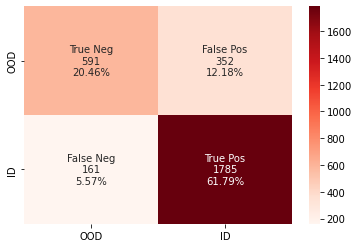

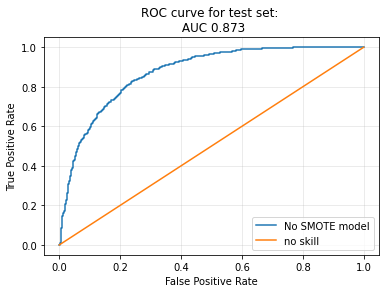

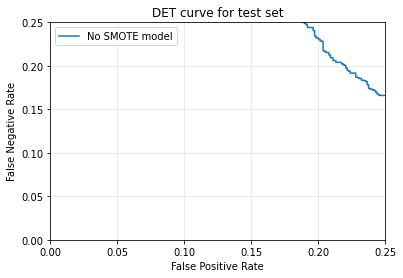

,features,weights,weights_abs
16,s_var,2.046543,2.046543
6,r_g_corr,1.760512,1.760512
2,b_avg,1.719424,1.719424
10,contrast,-1.174560,1.174560
8,g_b_corr,1.005652,1.005652
3,r_var,-0.975419,0.975419
7,r_b_corr,-0.971336,0.971336
13,s_avg,-0.859302,0.859302
5,b_var,-0.740656,0.740656
14,l_avg,-0.716849,0.716849


Logistic Regression + SMOTE:


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.8732571585512987
F1: 0.7859838047963129
Accuracy ID: 0.8350462487153134
Accuracy OOD: 0.750795334040297
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.69      0.75      0.72       943
    in-distribution       0.87      0.84      0.85      1946

           accuracy                           0.81      2889
          macro avg       0.78      0.79      0.79      2889
       weighted avg       0.81      0.81      0.81      2889

Accuracy: 0.80754586362063
Precision OOD: 0.8736559139784946
Recall OOD: 0.8350462487153134


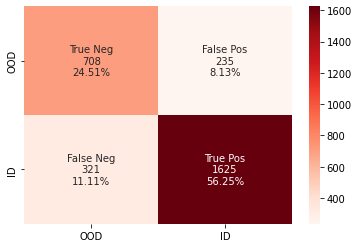

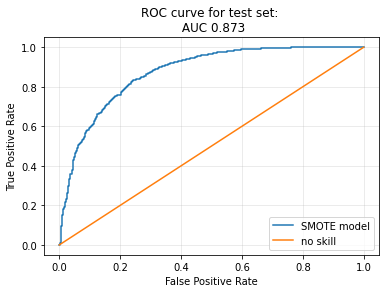

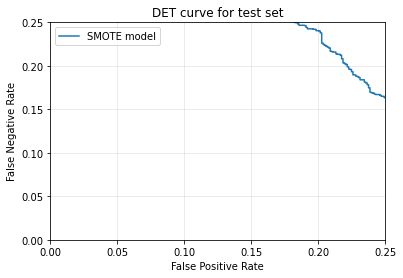

,features,weights,weights_abs
16,s_var,2.540652,2.540652
6,r_g_corr,2.173283,2.173283
2,b_avg,1.867584,1.867584
13,s_avg,-1.349074,1.349074
10,contrast,-1.290869,1.290869
7,r_b_corr,-1.269945,1.269945
8,g_b_corr,1.259848,1.259848
3,r_var,-1.114964,1.114964
5,b_var,-0.974162,0.974162
14,l_avg,-0.666962,0.666962


XGBoost + SMOTE:
AUC: 0.888029827614957
F1: 0.8057974926970717
Accuracy ID: 0.8586844809866393
Accuracy OOD: 0.7613997879109226
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.72      0.76      0.74       943
    in-distribution       0.88      0.86      0.87      1946

           accuracy                           0.83      2889
          macro avg       0.80      0.81      0.81      2889
       weighted avg       0.83      0.83      0.83      2889

Accuracy: 0.8269297334717896
Precision OOD: 0.8813291139240507
Recall OOD: 0.8586844809866393


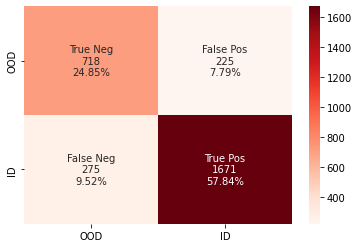

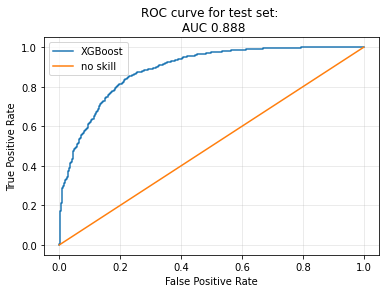

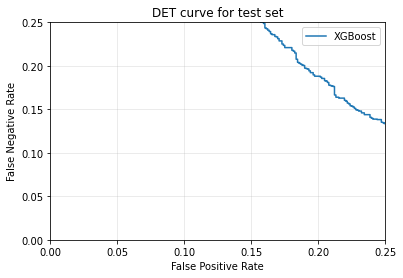

In [5]:
#logistic regression with no SMOTE
no_smote_model = logistic_regression_model_metrics(X_train, X_test, y_train, y_test,smote_flag=False)
#logistic regression with SMOTE
smote_model = logistic_regression_model_metrics(X_train, X_test, y_train, y_test,smote_flag=True)
#XGBoost with SMOTE 
xgb_model = xgbmodel_metrics(X_train, X_test, y_train, y_test)

# Testing on bollworms-test

100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


AUC: 0.8775902817167707
F1: 0.8043805920292706
Accuracy ID: 0.9255813953488372
Accuracy OOD: 0.6554878048780488
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.82      0.66      0.73       328
    in-distribution       0.84      0.93      0.88       645

           accuracy                           0.83       973
          macro avg       0.83      0.79      0.80       973
       weighted avg       0.83      0.83      0.83       973

Accuracy: 0.8345323741007195
Precision OOD: 0.8408450704225352
Recall OOD: 0.9255813953488372


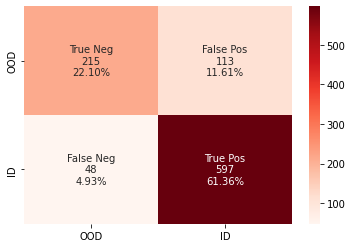

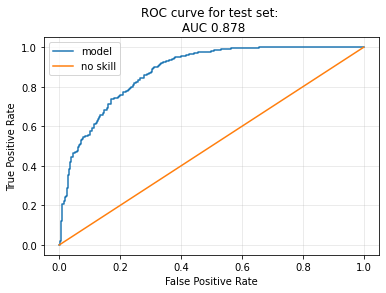

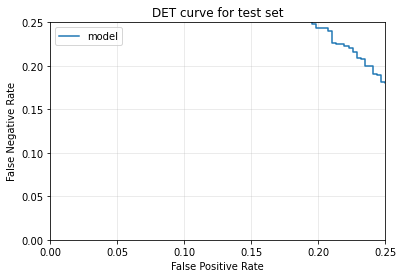

,features,weights,weights_abs
16,s_var,2.046543,2.046543
6,r_g_corr,1.760512,1.760512
2,b_avg,1.719424,1.719424
10,contrast,-1.174560,1.174560
8,g_b_corr,1.005652,1.005652
3,r_var,-0.975419,0.975419
7,r_b_corr,-0.971336,0.971336
13,s_avg,-0.859302,0.859302
5,b_var,-0.740656,0.740656
14,l_avg,-0.716849,0.716849


In [6]:
x_test_ood, y_test_ood = simple_model_generate_features(test_ood_ds,ood=True,pct_whiteish_threshold=0.9)
x_test_id, y_test_id = simple_model_generate_features(test_id_ds,ood=False,pct_whiteish_threshold=0.9)
x_test_ood_scaled = scaler_train.transform(x_test_ood)
x_test_id_scaled = scaler_train.transform(x_test_id)
holdout_x= np.vstack((x_test_id_scaled,x_test_ood_scaled))
holdout_y= np.vstack((y_test_id.reshape(-1,1),y_test_ood.reshape(-1,1)))
return_metrics(no_smote_model,holdout_x,holdout_y)

AUC: 0.8771459633200983
F1: 0.7741841623050251
Accuracy ID: 0.8186046511627907
Accuracy OOD: 0.7439024390243902
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.68      0.74      0.71       328
    in-distribution       0.86      0.82      0.84       645

           accuracy                           0.79       973
          macro avg       0.77      0.78      0.77       973
       weighted avg       0.80      0.79      0.80       973

Accuracy: 0.7934224049331963
Precision OOD: 0.8627450980392157
Recall OOD: 0.8186046511627907


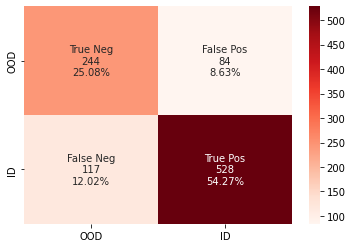

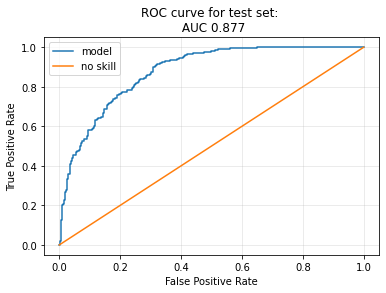

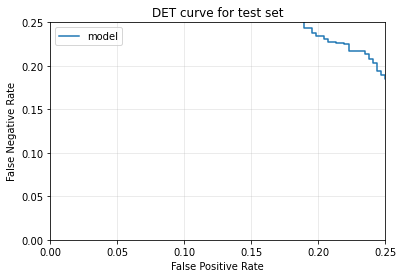

,features,weights,weights_abs
16,s_var,2.540652,2.540652
6,r_g_corr,2.173283,2.173283
2,b_avg,1.867584,1.867584
13,s_avg,-1.349074,1.349074
10,contrast,-1.290869,1.290869
7,r_b_corr,-1.269945,1.269945
8,g_b_corr,1.259848,1.259848
3,r_var,-1.114964,1.114964
5,b_var,-0.974162,0.974162
14,l_avg,-0.666962,0.666962


In [7]:
return_metrics(smote_model,holdout_x,holdout_y)

AUC: 0.8860725089809037
F1: 0.801685361671024
Accuracy ID: 0.8558139534883721
Accuracy OOD: 0.7530487804878049
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.73      0.75      0.74       328
    in-distribution       0.87      0.86      0.86       645

           accuracy                           0.82       973
          macro avg       0.80      0.80      0.80       973
       weighted avg       0.82      0.82      0.82       973

Accuracy: 0.8211716341212744
Precision OOD: 0.8720379146919431
Recall OOD: 0.8558139534883721


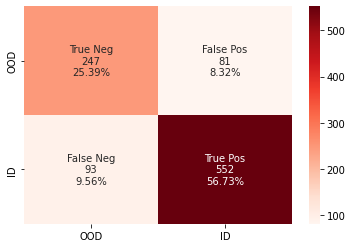

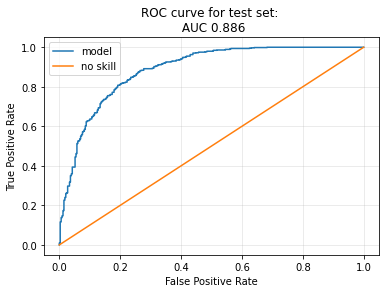

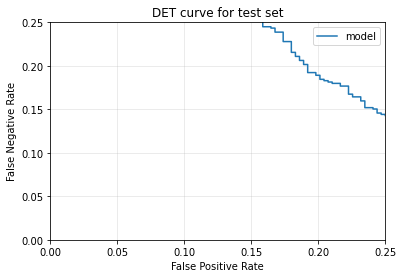

In [8]:
return_metrics(xgb_model,holdout_x,holdout_y)

# Visualize ID probability and threshold to maximize F1

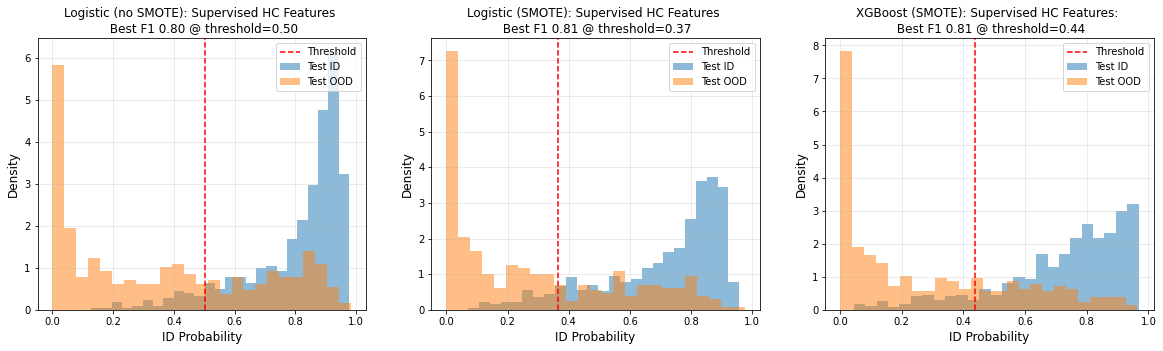

In [9]:
from analysis.classifiers import get_auroc, get_f1_maximizing_threshold, get_classification_report

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 5))
scores_train_id = no_smote_model.predict_proba(x_test_id_scaled)[:,1]
scores_train_ood = no_smote_model.predict_proba(x_test_ood_scaled)[:,1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)
ax1.hist(scores_train_id,label='Test ID', bins=25, alpha=0.5, density=True);
ax1.hist(scores_train_ood,label='Test OOD', bins=25, alpha=0.5, density=True);
ax1.set_xlabel('ID Probability', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title(f'Logistic (no SMOTE): Supervised HC Features \n Best F1 {max_f1_score:.2f} @ threshold={threshold:.2f}')
ax1.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

scores_train_id = smote_model.predict_proba(x_test_id_scaled)[:,1]
scores_train_ood = smote_model.predict_proba(x_test_ood_scaled)[:,1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)
ax2.hist(scores_train_id,label='Test ID', bins=25, alpha=0.5, density=True);
ax2.hist(scores_train_ood,label='Test OOD', bins=25, alpha=0.5, density=True);
ax2.set_xlabel('ID Probability', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title(f'Logistic (SMOTE): Supervised HC Features \n Best F1 {max_f1_score:.2f} @ threshold={threshold:.2f}')
ax2.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

scores_train_id = xgb_model.predict_proba(x_test_id_scaled)[:,1]
scores_train_ood = xgb_model.predict_proba(x_test_ood_scaled)[:,1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)
ax3.hist(scores_train_id,label='Test ID', bins=25, alpha=0.5, density=True);
ax3.hist(scores_train_ood,label='Test OOD', bins=25, alpha=0.5, density=True);
ax3.set_xlabel('ID Probability', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title(f'XGBoost (SMOTE): Supervised HC Features: \n Best F1 {max_f1_score:.2f} @ threshold={threshold:.2f}')
ax3.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax3.legend(loc='upper right')
ax3.grid(alpha=0.3)

* XGBoost with SMOTE performs the best, returning an F1 score of 0.89.

# Evaluation metrics for best model (XGboost) with threshold that maximizes F1 score

In [10]:
scores_test_id = xgb_model.predict_proba(x_test_id_scaled)[:,1]
scores_test_ood = xgb_model.predict_proba(x_test_ood_scaled)[:,1]
best_threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)

# Compute and report all classifier metrics of interest 
auc = get_auroc(scores_test_id, scores_test_ood)
class_report, conf_matrix = get_classification_report(scores_test_id, scores_test_ood, best_threshold)
per_class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Classification report on test set:')
print('')
print(class_report)
print(f'OOD accuracy: {per_class_accuracy[0]:.3f}')
print(f' ID accuracy: {per_class_accuracy[1]:.3f}')
print('')
print('Breakdown:', {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
print('')
print(f'AUC: {auc:.3f}')
print('')

Classification report on test set:

              precision    recall  f1-score   support

      OOD: 0      0.769     0.723     0.745       328
       ID: 1      0.863     0.890     0.876       645

    accuracy                          0.834       973
   macro avg      0.816     0.806     0.811       973
weighted avg      0.832     0.834     0.832       973

OOD accuracy: 0.723
 ID accuracy: 0.890

Breakdown: {'TN': 237, 'FP': 91, 'FN': 71, 'TP': 574}

AUC: 0.886



### Results in technical report
* AUROC: 0.886
* Macro-F1:  0.811
* Acc. (ID): 0.890
* Acc. (OOD): 0.723

# External datasets

In [11]:
from sklearn.metrics import accuracy_score
x_test_flowers, y_test_flowers = simple_model_generate_features(flowers102_ds,ood=True,pct_whiteish_threshold=0.9)
x_test_flowers_scaled = scaler_train.transform(x_test_flowers)
flowers_preds = xgb_model.predict(x_test_flowers_scaled)
print("============")
print("Accuracy score for Oxford flowers:",accuracy_score(flowers_preds,y_test_flowers.reshape(-1,1)))

100%|██████████| 51/51 [00:56<00:00,  1.11s/it]

Accuracy score for Oxford flowers: 0.9993827160493827


In [12]:
x_test_dog, y_test_dog = simple_model_generate_features(stanford_dogs_ds,ood=True,pct_whiteish_threshold=0.9)
x_test_dog_scaled = scaler_train.transform(x_test_dog)
dog_preds = xgb_model.predict(x_test_dog_scaled)
print("============")
print("Accuracy score for Stanford dogs:",accuracy_score(dog_preds,y_test_dog.reshape(-1,1)))

100%|██████████| 94/94 [01:43<00:00,  1.10s/it]

Accuracy score for Stanford dogs: 0.9933333333333333
